### * Домашнее задание: Многоклассовая классификация

В текущем домашнем задание предлагается построить модель многоклассовой классификации для показателя `RiskVar`. Воспользуемся другими частями датасета freMPL (1 и 2).

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from hyperopt import hp, tpe, space_eval
from hyperopt.fmin import fmin
from hyperopt import fmin, tpe, hp, STATUS_OK

from sklearn.metrics import precision_score, f1_score, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
import warnings
warnings.simplefilter('ignore')

In [2]:
def SeriesFactorizer(series):
    series, unique = pd.factorize(series)
    reference = {x: i for x, i in enumerate(unique)}
    print(reference)
    return series, reference

In [3]:
df = pd.read_csv('freMPL-R.csv', low_memory=False)

In [4]:
df = df.loc[df.Dataset.isin([1, 2])]
df.drop('Dataset', axis=1, inplace=True)
df.dropna(axis=1, how='all', inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
df.head()

,Exposure,LicAge,RecordBeg,RecordEnd,VehAge,Gender,MariStat,SocioCateg,VehUsage,DrivAge,...,VehBody,VehPrice,VehEngine,VehEnergy,VehMaxSpeed,VehClass,ClaimAmount,RiskVar,Garage,ClaimInd
0,0.583,366,2004-06-01,NaN,2,Female,Other,CSP1,Professional,55,...,sedan,D,injection,regular,160-170 km/h,B,0.000000,15.0,None,0
1,0.200,187,2004-10-19,NaN,0,Male,Alone,CSP55,Private+trip to office,34,...,microvan,K,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,20.0,None,0
2,0.083,169,2004-07-16,2004-08-16,1,Female,Other,CSP1,Professional,33,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,None,0
3,0.375,170,2004-08-16,NaN,1,Female,Other,CSP1,Professional,34,...,other microvan,L,direct injection overpowered,diesel,170-180 km/h,M1,0.000000,17.0,Private garage,0
4,0.500,224,2004-01-01,2004-07-01,3,Male,Other,CSP47,Professional,53,...,van,L,direct injection overpowered,diesel,140-150 km/h,0,1418.610272,19.0,None,1


In [6]:
df.iloc[0]

Exposure              0.583
LicAge                  366
RecordBeg        2004-06-01
RecordEnd               NaN
VehAge                    2
Gender               Female
MariStat              Other
SocioCateg             CSP1
VehUsage       Professional
DrivAge                  55
HasKmLimit                0
BonusMalus               72
VehBody               sedan
VehPrice                 D 
VehEngine         injection
VehEnergy           regular
VehMaxSpeed    160-170 km/h
VehClass                  B
ClaimAmount               0
RiskVar                  15
Garage                 None
ClaimInd                  0
Name: 0, dtype: object

In [7]:
df.drop(['RecordBeg', 'RecordEnd'], axis=1, inplace=True)

In [8]:
df.Gender, GenderRef = SeriesFactorizer(df.Gender)

{0: 'Female', 1: 'Male'}


In [9]:
df.MariStat, MariStatRef = SeriesFactorizer(df.MariStat)

{0: 'Other', 1: 'Alone'}


In [10]:
# df['SocioCateg'] = df.SocioCateg.str.slice(0, 4)

In [11]:
cols = df.columns

In [12]:
num_feats = df.select_dtypes(include='float64').columns.tolist() + df.select_dtypes(include='int64').columns.tolist()
num_feats

['Exposure',
 'ClaimAmount',
 'RiskVar',
 'LicAge',
 'Gender',
 'MariStat',
 'DrivAge',
 'HasKmLimit',
 'BonusMalus',
 'ClaimInd']

In [13]:
cat_feats = df.select_dtypes(include='object').columns.tolist()
cat_feats

['VehAge',
 'SocioCateg',
 'VehUsage',
 'VehBody',
 'VehPrice',
 'VehEngine',
 'VehEnergy',
 'VehMaxSpeed',
 'VehClass',
 'Garage']

In [14]:
df_2 = pd.get_dummies(df, columns=cat_feats)

In [15]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Columns: 140 entries, Exposure to Garage_Private garage
dtypes: float64(3), int64(7), uint8(130)
memory usage: 8.2 MB


In [16]:
df_2.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,...,VehMaxSpeed_220+ km/h,VehClass_0,VehClass_A,VehClass_B,VehClass_H,VehClass_M1,VehClass_M2,Garage_Collective garage,Garage_None,Garage_Private garage
0,0.583,366,0,0,55,0,72,0.000000,15.0,0,...,0,0,0,1,0,0,0,0,1,0
1,0.200,187,1,1,34,0,80,0.000000,20.0,0,...,0,0,0,0,0,1,0,0,1,0
2,0.083,169,0,0,33,0,63,0.000000,17.0,0,...,0,0,0,0,0,1,0,0,1,0
3,0.375,170,0,0,34,0,63,0.000000,17.0,0,...,0,0,0,0,0,1,0,0,0,1
4,0.500,224,1,0,53,0,72,1418.610272,19.0,1,...,0,1,0,0,0,0,0,0,1,0


In [17]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40732 entries, 0 to 40731
Columns: 140 entries, Exposure to Garage_Private garage
dtypes: float64(3), int64(7), uint8(130)
memory usage: 8.2 MB


XGBoost для многоклассовой классификации принимает на вход значения меток классов в виде `[0, num_classes]`. Поэтому, вычтем из значений переменной `RiskVar` единицу.

In [18]:
df_2.RiskVar -= 1
df_2.RiskVar.value_counts()

15.0    4906
14.0    4625
16.0    3444
19.0    2894
18.0    2773
12.0    2719
17.0    2614
10.0    2533
11.0    2445
13.0    2096
6.0     1634
7.0     1439
9.0     1314
8.0     1170
4.0      979
5.0      902
2.0      660
3.0      603
0.0      531
1.0      451
Name: RiskVar, dtype: int64

Данная переменная принимает значения от 1 до 20, которые, возможно, упорядочены. Посмотрим, сколько полисов соответствуют каждому из значений `RiskVar`, используя метод `groupby`. Для полученных значений также посчитаем нормированную частоту.

In [19]:
data = df_2.groupby('RiskVar')['RiskVar'].count().to_frame()
data = data.rename(columns={"RiskVar": "Count"})

In [20]:
FreqCount = pd.DataFrame(data, columns=['Count'])
FreqCount['Freq'] = FreqCount['Count'] / FreqCount['Count'].sum()
FreqCount

,Count,Freq
RiskVar,,
0.0,531,0.013036
1.0,451,0.011072
2.0,660,0.016203
3.0,603,0.014804
4.0,979,0.024035
5.0,902,0.022145
6.0,1634,0.040116
7.0,1439,0.035328
8.0,1170,0.028724


In [21]:
FreqCount.Freq.sum()

1.0

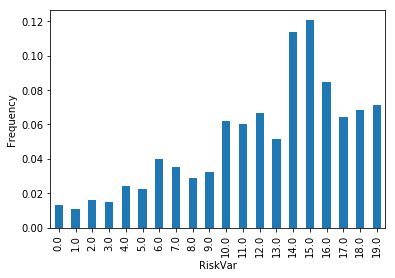

In [22]:
FreqCount.Freq.plot(kind='bar')
plt.ylabel('Frequency')
plt.show()

In [23]:
FreqCount

,Count,Freq
RiskVar,,
0.0,531,0.013036
1.0,451,0.011072
2.0,660,0.016203
3.0,603,0.014804
4.0,979,0.024035
5.0,902,0.022145
6.0,1634,0.040116
7.0,1439,0.035328
8.0,1170,0.028724


Заметим, что в данном случае присутствует проблема несбалансированности классов. Поэтому, для того, чтобы по возможности избежать ее, воспользуемся взвешиванием наблюдений для обучения модели. Для этого в исходном наборе данных создадим столбец `weight`. Присвоим ему некоторые значения, например, можно задать `0.5` для значений `RiskVar` 14 и 15, а для остальных - 1 (Для этого можем использовать функцию `np.where` и метод `isin` для `pandas.Series`). Также можно попробовать какой-либо другой способ задания весов.

In [24]:
df_2['weight'] = 1

In [25]:
df_2.loc[df_2.RiskVar.isin([14, 15]), 'weight'] = 0.5
df_2.head()

,Exposure,LicAge,Gender,MariStat,DrivAge,HasKmLimit,BonusMalus,ClaimAmount,RiskVar,ClaimInd,...,VehClass_0,VehClass_A,VehClass_B,VehClass_H,VehClass_M1,VehClass_M2,Garage_Collective garage,Garage_None,Garage_Private garage,weight
0,0.583,366,0,0,55,0,72,0.000000,14.0,0,...,0,0,1,0,0,0,0,1,0,0.5
1,0.200,187,1,1,34,0,80,0.000000,19.0,0,...,0,0,0,0,1,0,0,1,0,1.0
2,0.083,169,0,0,33,0,63,0.000000,16.0,0,...,0,0,0,0,1,0,0,1,0,1.0
3,0.375,170,0,0,34,0,63,0.000000,16.0,0,...,0,0,0,0,1,0,0,0,1,1.0
4,0.500,224,1,0,53,0,72,1418.610272,18.0,1,...,1,0,0,0,0,0,0,1,0,1.0


In [26]:
df_2.weight.value_counts()

1.0    31201
0.5     9531
Name: weight, dtype: int64

Разобьем имеющийся набор данных на обучающую, валидационную и тестовую выборки в отношениях 70%/15%/15% соответственно. Зададим зерно для случайного разбиения равным 10.

In [27]:
cols = df_2.columns.drop('RiskVar').tolist()

In [28]:
x_train, x_test, y_train, y_test = train_test_split(df_2[cols], df_2.RiskVar, test_size=0.3, random_state=10)
x_valid, x_test, y_valid, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)

Далее, создадим объекты `DMatrix` для обучающей, валидационной и тестовой выборок. Для обучающей выборки также укажем параметр `weight` равным полученному ранее столбцу весов. Данный столбец также нужно исключить из объекта передаваемого в параметр `data`.

In [29]:
xgb_train = xgb.DMatrix(x_train.drop(['weight'], axis=1), (y_train), weight=x_train.weight)
xgb_valid = xgb.DMatrix(x_valid.drop(['weight'], axis=1), (y_valid))
xgb_test = xgb.DMatrix(x_test.drop(['weight'], axis=1), (y_test))

Для оптимизации гиперпараметров можно воспользоваться различными методами. Однако, в случае Hyperopt, на процесс подбора гиперпараметров может уйти немалое количество часов.

In [30]:
# Определим функцию для оптимизации гиперпараметров алгоритмом TPE

def objective(params):
    parameters = {
        'objective': 'multi:softmax',
        'num_class': 20,
        'max_depth':  int(params['max_depth']),
        'min_child_weight': params['min_child_weight'],
        'subsample': params['subsample'],
        'colsample_bytree': params['colsample_bytree'],
        'eta': params['eta'],
        'alpha': params['alpha'],
        'lambda': params['lambda']
    }
    cv_result = xgb.cv(parameters, 
                       xgb_train, 
                       num_boost_round=int(params['num_boost_round']), 
                       nfold=5, 
                       seed=0, 
                       early_stopping_rounds=10)
    score = cv_result['test-merror-mean'][-1:].values[0]
    return score

In [31]:
# Определим границы, в которых будем искать гиперпараметры 

space = {'num_boost_round': hp.quniform('num_boost_round', 50, 500, 1),
         'max_depth': hp.choice('max_depth', [5, 8, 10, 12, 15]),
         'min_child_weight': hp.uniform('min_child_weight', 0, 50),
         'subsample': hp.uniform('subsample', 0.5, 1),
         'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
         'alpha': hp.uniform('alpha', 0.8, 1),
         'lambda': hp.uniform('lambda', 0, 1),
         'eta': hp.uniform('eta', 0.01, 1),
         'num_class': 20
        }

In [32]:
%%time

best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [8:26:14<00:00, 673.19s/it, best loss: 0.691462]
Wall time: 8h 26min 14s


In [33]:
best

{'alpha': 0.9097784080817496,
 'colsample_bytree': 0.7824362321939782,
 'eta': 0.45477420424481774,
 'lambda': 0.33274188103592317,
 'max_depth': 4,
 'min_child_weight': 0.8825140879177018,
 'num_boost_round': 189.0,
 'subsample': 0.7771573617837005}

In [34]:
# Оптимальные гиперпараметры 

best_params = space_eval(space, best)
best_params['objective'] = 'multi:softmax'
best_params

{'alpha': 0.9097784080817496,
 'colsample_bytree': 0.7824362321939782,
 'eta': 0.45477420424481774,
 'lambda': 0.33274188103592317,
 'max_depth': 15,
 'min_child_weight': 0.8825140879177018,
 'num_boost_round': 189.0,
 'num_class': 20,
 'subsample': 0.7771573617837005,
 'objective': 'multi:softmax'}

Далее обучим нашу модель с оптимальными параметрами

In [35]:
num_round = 500

In [36]:
bst = xgb.train(best_params, xgb_train, num_round)

In [37]:
preds_train = bst.predict(xgb_train)
print("y_train predictions precision score:", precision_score(y_train, preds_train, average='macro'))

y_train predictions precision score: 0.9999748237663646


In [38]:
preds_valid = bst.predict(xgb_valid)
print("y_valid predictions precision score:", precision_score(y_valid, preds_valid, average='macro'))

y_valid predictions precision score: 0.4352787628317194


In [39]:
preds_test = bst.predict(xgb_test)
print("y_test predictions precision score:", precision_score(y_test, preds_test, average='macro'))

y_test predictions precision score: 0.42587392570710436


Посчитаем метрики accuracy и f1 на наших наборах данных, также можем визуализировать confusion matrix, например, с помощью `plt.imshow()`. Можно использовать предложенный ниже код.

In [40]:
dfsets = [{'set': 'train', 'dmat': xgb_train, 'target': y_train},
          {'set': 'valid', 'dmat': xgb_valid, 'target': y_valid},
          {'set': 'test', 'dmat': xgb_test, 'target': y_test}]

for dfset in dfsets:
    class_preds = bst.predict(dfset['dmat'])
    print('F1 Score on ' + str(dfset['set']) + ':', 
          f1_score(dfset['target'], class_preds, average='micro')) 
    print('Precision Score on ' + str(dfset['set']) + ':',
          precision_score(dfset['target'], class_preds, average='macro')) 
    print('Accuracy on ' + str(dfset['set']) + ':', 
          accuracy_score(dfset['target'], class_preds))
    print()

F1 Score on train: 0.9999649270482603
Precision Score on train: 0.9999748237663646
Accuracy on train: 0.9999649270482603

F1 Score on valid: 0.38379705400981995
Precision Score on valid: 0.4352787628317194
Accuracy on valid: 0.38379705400981995

F1 Score on test: 0.3765957446808511
Precision Score on test: 0.42587392570710436
Accuracy on test: 0.37659574468085105



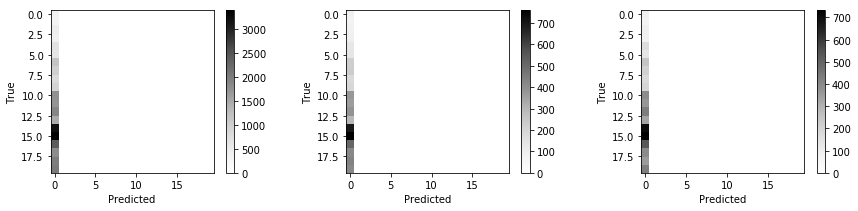

In [41]:
plt.subplots(1,3, figsize=(15,3))
for i in range(len(dfsets)):
    confmatrix = confusion_matrix(dfsets[i]['target'], \
                                  np.asarray([np.argmax(line) for line in bst.predict(dfsets[i]['dmat'])]))
    plt.subplot(1,3,i+1)
    plt.imshow(confmatrix, cmap='Greys')
    plt.colorbar()
    plt.ylabel('True')
    plt.xlabel('Predicted')
plt.show()

Как вы оцениваете качество построенной модели? Какие проблемы могут здесь присутствовать? Как можно улучшить результат?

#### Налицо переобучение.

#### Нужно поработать над признаками, признаков слишком много. Можно попробовать метод главных компонент.